Big Data Computing (2022-2023) Project

**Elena Jiang 1846716**

# **Table of Contents**

1. Global Constants

2. Dependences

3. Spark and Google Colab Setup
    
    3.1. Create Spark context

    3.2. Link Colab to our Google Drive

    3.3. Check everything is ok
  
4. Dataset

    4.1.  Get Dataset

    4.2.  Missing value

    4.3.  Data processing
    
    4.4.  Graph

    4.5.  Save csv
  
5. Handle Imbalanced Dataset

    5.1.  Resampling

6. Clustering

    6.1.  K-means

    6.2.  Save DataFrame

7. Classification

    7.1.  Random Forest 

    7.2.  Logistic Regression

8. Web App

# **Abstract**
The main goal of the project is to use the US Accidents dataset to develop a deep understanding of the patterns and trends related to accidents occurring on US roads. This understanding will enable the development of data-driven strategies to enhance road safety measures and reduce accidents.

# **1. Global Constants**

In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"

GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/2022-23BigData/datasets"

DATASET_URL = "https://github.com/jngelena/bigdata_project/raw/main/bigdata_project-main/US_Accidents_March23.csv.zip"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]

RANDOM_SEED = 42
MAX_K_CLUSTERS = 50

# **2. Dependences**

In [ ]:
!pip install pyspark # install pyspark
!pip install geopandas

!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

In [ ]:
#import useful package
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer, Normalizer, OneHotEncoder
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.metrics import confusion_matrix

#from google.colab import drive

import requests
import zipfile
import tempfile

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import fiona

# **3. Spark and Google Colab Setup**

## **3.1.** Create Spark context

In [3]:
# Create the session
conf = SparkConf().\
    set('spark.executor.memory', '4G').\
    set('spark.driver.memory', '45G').\
    set('spark.driver.maxResultSize', '10G').\
    set('spark.sql.autoBroadcastJoinThreshold', '100M').\
    set('spark.sql.debug.maxToStringFields', '1000').\
    set('spark.executor.extraJavaOptions', '-Dnetlib.blas.DRIVER=nomkl')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/13 19:18:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## **3.2.** Link Colab to our Google Drive

In [ ]:
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


## **3.3.** Check everything is ok

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.app.startTime', '1694810898890'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-ope

# **4. Dataset**

## **4.1.** Get Dataset

In [ ]:
"""
This function downloads a file from a specific URL directly to Google Drive.
"""
def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200: # Test if everything went ok
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size):
        if block:
          file.write(block)

In [ ]:
get_data(DATASET_URL, GDRIVE_DATASET_FILE)

In [ ]:
"""
This function unzip a csv file and load it in pyspark dataframe.
"""
def read_csv_from_zip(zip_path, csv_filename):
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        if csv_filename not in zip_file.namelist():
            print(f"CSV file '{csv_filename}' not found in the zip archive.")
            return

        with zip_file.open(csv_filename) as csv_file:
            with tempfile.NamedTemporaryFile(delete=False) as temp_file:
                temp_filename = temp_file.name
                temp_file.write(csv_file.read())

        csv_data_df = spark.read.csv(temp_filename, header=True)
        return csv_data_df

In [ ]:
csv_filename = "US_Accidents_March23.csv"
df = read_csv_from_zip(GDRIVE_DATASET_FILE, csv_filename)
print("The shape of the dataset is {:d} rows by {:d} columns".format(df.count(), len(df.columns)))

The shape of the dataset is 7728394 rows by 46 columns


### **4.1.1.** Schema


In [ ]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): string (nullable = true)
 |-- Wind_Chill(F): string (nullable = true)
 |-- Humidity(%): string (nullable = true)
 |-- Pressure(in): string (nullable = true)
 |-- Visibility(

In [ ]:
df.show()

+----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|A

## **4.2.** Missing value


In [ ]:
missing_df = df.select([col(column).isNull().cast('int').alias(column) for column in df.columns]) \
               .groupBy().sum().collect()
missing_df = spark.createDataFrame([(column, count) for column, count in zip(df.columns, missing_df[0])],
                                   ['column_name', 'missing_value'])
missing_df = missing_df.filter(missing_df.missing_value > 0)
missing_df = missing_df.sort('missing_value')

missing_df.show()

+--------------------+-------------+
|         column_name|missing_value|
+--------------------+-------------+
|         Description|            5|
|                City|          253|
|             Zipcode|         1915|
|            Timezone|         7808|
|              Street|        10869|
|        Airport_Code|        22635|
|      Sunrise_Sunset|        23246|
|      Civil_Twilight|        23246|
|   Nautical_Twilight|        23246|
|Astronomical_Twil...|        23246|
|   Weather_Timestamp|       120228|
|        Pressure(in)|       140679|
|      Temperature(F)|       163853|
|   Weather_Condition|       173459|
|         Humidity(%)|       174144|
|      Wind_Direction|       175206|
|      Visibility(mi)|       177098|
|     Wind_Speed(mph)|       571233|
|       Wind_Chill(F)|      1999019|
|   Precipitation(in)|      2203586|
+--------------------+-------------+
only showing top 20 rows



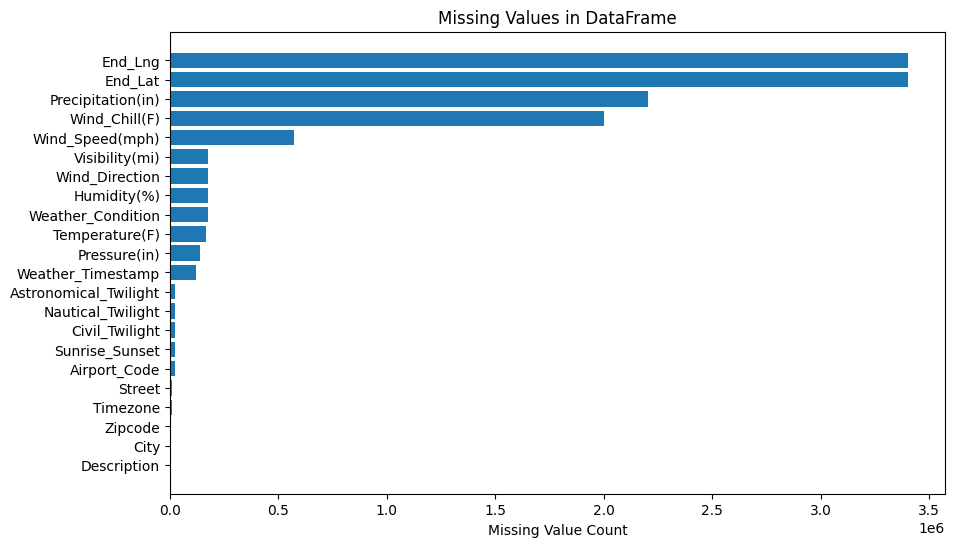

In [ ]:
columns = missing_df.select('column_name').rdd.flatMap(lambda x: x).collect()
missing_values = missing_df.select('missing_value').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.barh(columns, missing_values)
plt.xlabel('Missing Value Count')
plt.title('Missing Values in DataFrame')

plt.show()

## **4.3.** Data processing


### **4.3.1.** Remove columns


In [ ]:
unique_values = df.select('Country', 'Timezone').distinct()
unique_values.show()

+-------+-----------+
|Country|   Timezone|
+-------+-----------+
|     US| US/Eastern|
|     US|US/Mountain|
|     US| US/Central|
|     US| US/Pacific|
|     US|       null|
+-------+-----------+



Remove different rows:
- 'Country': because the country is always the same;\
- 'End_Lat', 'End_Lng: there is 'Distance' feature that I can use, even for small distances they take null value;\
- 'Zipcode', 'Airport_Code', 'Timezone', 'Source': not so important for our analysis


In [ ]:
columns_to_remove = ['Country', 'Zipcode', 'Airport_Code',
                     'Timezone', 'Source', 'End_Lat', 'End_Lng']
df = df.drop(*columns_to_remove)

### **4.3.2.** Feature importance
Feature importance analysis is an essential step in the data processing. It provides valuable insights into which features in the dataset have the most significant impact on the target variable.

In [ ]:
"""
This function appears to perform feature importance analysis using a Random Forest classifier.
"""
def feature_importance_train (transformed_df, feature_cols):
  (training_data, testing_data) = transformed_df.randomSplit([0.7, 0.3], seed=RANDOM_SEED)
  rf2 = RandomForestClassifier(featuresCol="features", labelCol="label")
  rf_model = rf2.fit(training_data)

  feature_importance = rf_model.featureImportances
  importance_dict = dict(zip(feature_cols, feature_importance))
  sorted_importance = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))

  for feature, importance in sorted_importance.items():
    print(f"{feature}: {importance}")

In [ ]:
"""
This function designed to perform feature importance analysis using machine learning techniques.
"""
def feature_importance(feature_cols, dataframe=df):
  assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
  indexer = StringIndexer(inputCol="Severity", outputCol="label")

  pipeline = Pipeline(stages=[indexer, assembler])
  model = pipeline.fit(dataframe)
  transformed_df = model.transform(dataframe)

  feature_importance_train(transformed_df, feature_cols)

#### **4.3.2.1.** Boolean features


In [ ]:
boolean_cols = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction",
                "No_Exit", "Railway", "Roundabout", "Station", "Stop",
                "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]

for col_name in boolean_cols:
    df = df.withColumn(col_name, col(col_name).cast("boolean"))

In [ ]:
feature_importance(boolean_cols)

Crossing: 0.36618646408963007
Traffic_Signal: 0.3367324281770198
Stop: 0.11960149331310885
Station: 0.08743822961258305
Junction: 0.039216325272380205
Amenity: 0.03316583388845075
Railway: 0.013957254662026658
Traffic_Calming: 0.00243165640327819
No_Exit: 0.0007802680207185495
Bump: 0.00033019219319411553
Give_Way: 0.0001598543676098863
Roundabout: 0.0
Turning_Loop: 0.0


In [ ]:
# Remove columns with rate <0.1
columns_to_remove = ['Turning_Loop', 'Station', 'Amenity',
                     'Railway', 'Traffic_Calming', 'No_Exit',
                     'Give_Way', 'Roundabout', 'Bump', 'Junction']
df = df.drop(*columns_to_remove)

#### **4.3.2.2.** Numerical columns


In [ ]:
numerical_cols = ["Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
                  "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]

for col_name in numerical_cols:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

# Impute (fill in) missing values using the mean along each column (for default)
imputer = Imputer(inputCols=numerical_cols, outputCols=[col + "_imputed" for col in numerical_cols])
imputer_model = imputer.fit(df)
transformed_df_num = imputer_model.transform(df)

In [ ]:
numerical_cols_imputed = [col + "_imputed" for col in numerical_cols]
feature_importance(numerical_cols_imputed,transformed_df_num)

Wind_Chill(F)_imputed: 0.4859356632808456
Precipitation(in)_imputed: 0.355562034723957
Wind_Speed(mph)_imputed: 0.08595761515751028
Pressure(in)_imputed: 0.054836041607295036
Visibility(mi)_imputed: 0.007635388907112014
Humidity(%)_imputed: 0.005592326750254388
Temperature(F)_imputed: 0.004480929573025873


In [ ]:
# Remove columns with rate <0.08
columns_to_remove = ['Temperature(F)', 'Visibility(mi)', "Humidity(%)", "Pressure(in)"]
df = df.drop(*columns_to_remove)

## **4.4.** Graph
The code combines accident data with US boundaries to create a map that visualizes the geographic distribution of accidents across the United States. It helps in understanding where accidents are concentrated.

In [ ]:
selected_df = df.select("Severity", "Start_Lng", "Start_Lat")
pandas_df = selected_df.toPandas()

In [ ]:
GDRIVE_SHP_FILE = GDRIVE_DATA_DIR + '/us_state.shp'
DATASET_URL_SHP = "https://github.com/jngelena/bigdata_project/raw/main/bigdata_project-main/cb_2018_us_state_500k.shp"
get_data(DATASET_URL_SHP, GDRIVE_SHP_FILE)

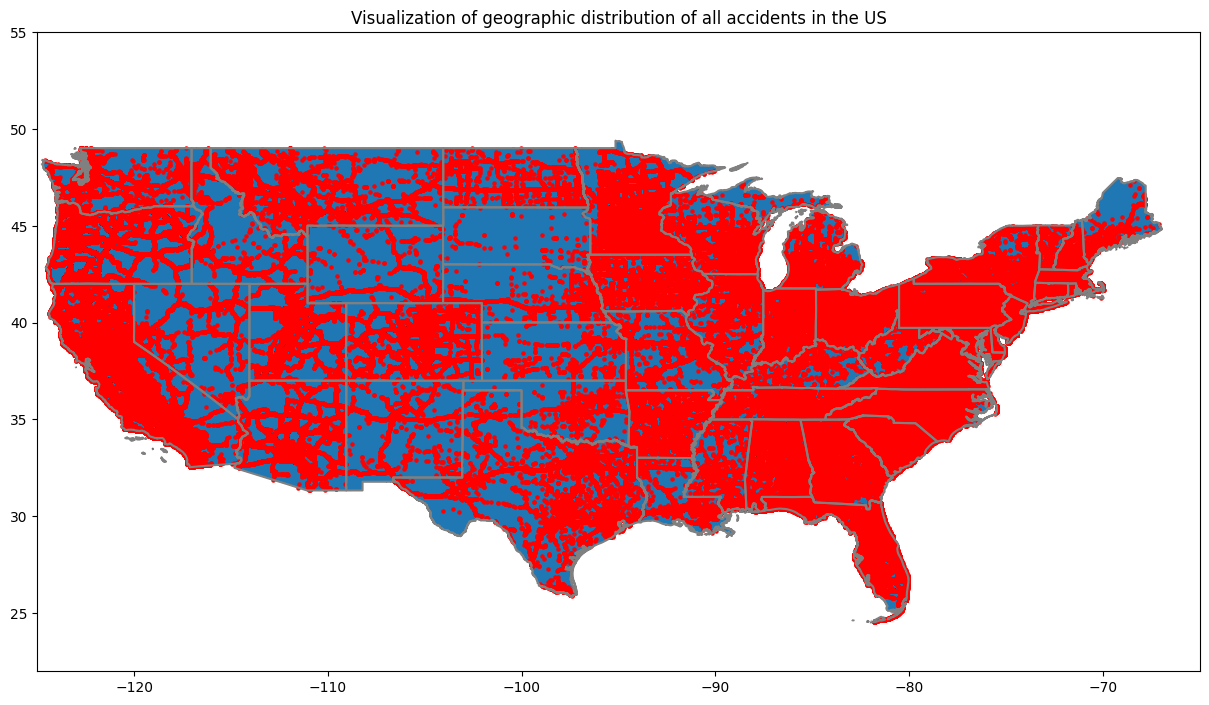

In [ ]:
# plot all the accidents in the US according to the latitude and longitude
with fiona.Env(SHAPE_RESTORE_SHX='YES'):
    geometry = gpd.points_from_xy(pandas_df['Start_Lng'], pandas_df['Start_Lat'])
    gdf = gpd.GeoDataFrame(pandas_df, geometry=geometry)
    shapefile_path = GDRIVE_SHP_FILE
    states = gpd.read_file(shapefile_path)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_xlim([-125, -65])
    ax.set_ylim([22, 55])

    states.boundary.plot(ax=ax, color='grey')
    states.plot(ax=ax, edgecolor='black', linewidth=0.5)
    gdf.plot(ax=ax, color='red', markersize=5)
    ax.set_facecolor('white')
    ax.set_title('Visualization of geographic distribution of all accidents in the US')
    plt.show()

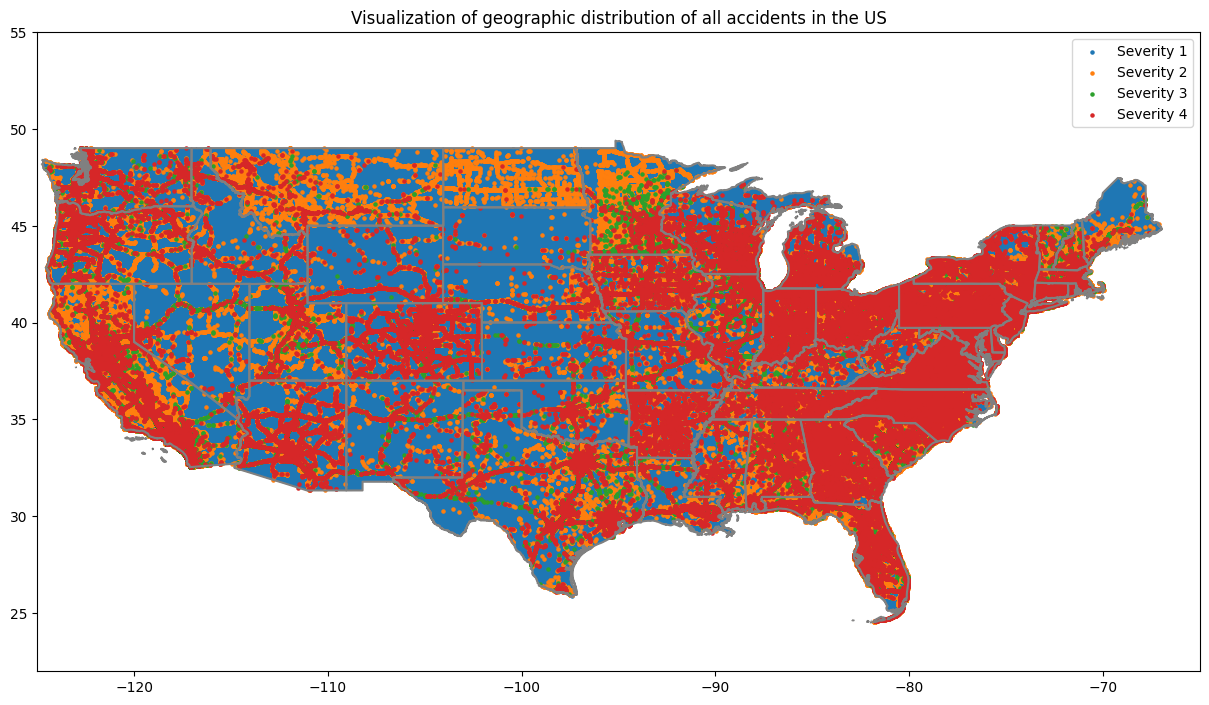

In [ ]:
# plot all the accidents in the US according to the latitude and longitude base on different severity
with fiona.Env(SHAPE_RESTORE_SHX='YES'):
    geometry = gpd.points_from_xy(pandas_df['Start_Lng'], pandas_df['Start_Lat'])
    gdf = gpd.GeoDataFrame(pandas_df, geometry=geometry)
    shapefile_path = GDRIVE_SHP_FILE
    states = gpd.read_file(shapefile_path)

    color_map = {1: 'green', 2: 'yellow', 3: 'orange', 4: 'red'}
    gdf['Severity_Color'] = gdf['Severity'].map(color_map)

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_xlim([-125, -65])
    ax.set_ylim([22, 55])

    states.boundary.plot(ax=ax, color='grey')
    states.plot(ax=ax, edgecolor='black', linewidth=0.5)

    for severity, data in gdf.groupby('Severity'):
        if not data.empty:
            color = color_map.get(severity)
            data.plot(ax=ax, marker='o', markersize=5, label=f"Severity {severity}", color=color)

    ax.set_facecolor('white')
    ax.set_title('Visualization of geographic distribution of all accidents in the US')
    ax.legend()
    plt.show()

## **4.5.** Save csv
Save the dataframe after data processing.

In [ ]:
print("The shape of the dataset after data processing is {:d} rows by {:d} columns".format(df.count(), len(df.columns)))

The shape of the dataset after data processing is 7728394 rows by 25 columns


In [ ]:
df.write.csv(GDRIVE_DATA_DIR + "/US_Accidents_March23_cleaned.csv", header=True, mode='overwrite')

### **4.5.1.** Check dataframe

In [ ]:
df.show()

+----+--------+-------------------+-------------------+------------------+------------------+------------+--------------------+--------------------+------------+----------+-----+-------------------+-------------+--------------+---------------+-----------------+-----------------+--------+-----+--------------+--------------+--------------+-----------------+---------------------+
|  ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|Distance(mi)|         Description|              Street|        City|    County|State|  Weather_Timestamp|Wind_Chill(F)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Crossing| Stop|Traffic_Signal|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+----+--------+-------------------+-------------------+------------------+------------------+------------+--------------------+--------------------+------------+----------+-----+-------------------+-------------+--------------+-------------

In [ ]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- Distance(mi): string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nullable = true)
 |-- Sunrise_Sunset: string (nullable = true)
 |-- Civil_Twilight: string (nullable = true)
 |-- Nautical_Twili

# **5. Handle Imbalanced Dataset**
The feature 'Severity' shows the severity of the accident, a number between 1 and 4, where 1 indicates the least impact on traffic (i.e., short delay)
 

In [5]:
df = df.select("*").withColumn("id_unique", monotonically_increasing_id())

In [ ]:
"""
This function plots the severity counts.
"""
def plot_graph(df):
    severity_counts = df.groupBy("Severity").count()
    severity_counts_pandas = severity_counts.toPandas()

    plt.bar(severity_counts_pandas["Severity"], severity_counts_pandas["count"])
    plt.xlabel("Severity")
    plt.ylabel("Count")
    plt.title("Severity Counts")
    plt.show()

In [ ]:
severity_counts = df.groupBy("Severity").count()
severity_counts.show()

+--------+-------+
|Severity|  count|
+--------+-------+
|       1|  67366|
|       3|1299337|
|       4| 204710|
|       2|6156981|
+--------+-------+



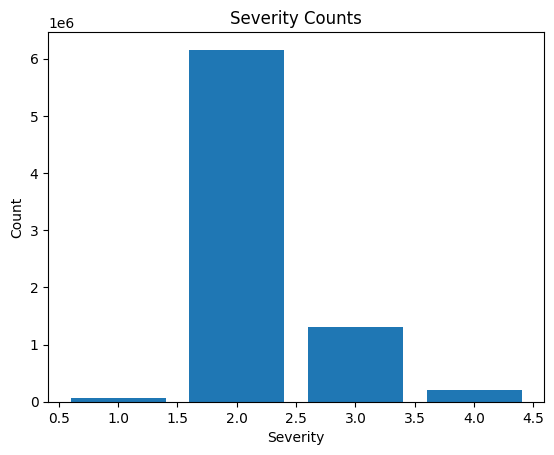

In [ ]:
plot_graph(df)

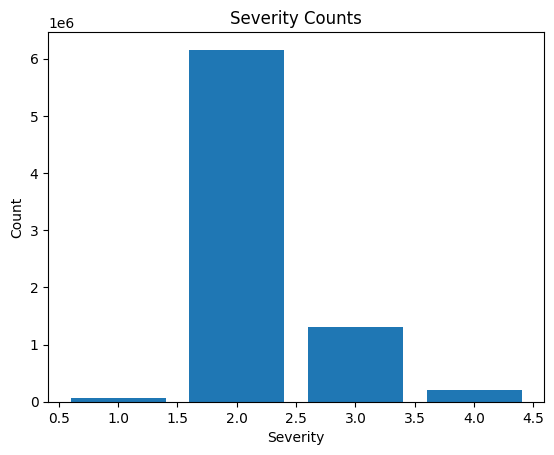

In [ ]:
df = df.dropna(subset=["Description"])
plot_graph(df)

## **5.1.** Resampling

In [6]:
downsample_fraction_severity2 = 0.065
condition_severity2 = col("Severity") == 2
condition_severity_other = ~condition_severity2
downsampled_data_severity2 = df.filter(condition_severity2).sample(fraction=downsample_fraction_severity2, seed=RANDOM_SEED)
downsampled_data = downsampled_data_severity2.union(df.filter(condition_severity_other))

downsample_fraction_severity3 = 0.3
condition_severity3= col("Severity") == 3
condition_severity_other = ~condition_severity3
downsampled_data_severity3 = df.filter(condition_severity3).sample(fraction=downsample_fraction_severity3, seed=RANDOM_SEED)
downsampled_data = downsampled_data_severity3.union(downsampled_data.filter(condition_severity_other))

In [ ]:
severity_counts = downsampled_data.groupBy("Severity").count()
severity_counts.show()

+--------+------+
|Severity| count|
+--------+------+
|       3|390711|
|       2|401141|
|       1| 67366|
|       4|204710|
+--------+------+



In [7]:
oversample_ratio = 1.0 
oversampled_df_4 = df.filter((col("Severity") == 4)).sample(True, oversample_ratio, seed=RANDOM_SEED)

oversample_ratio = 5.0
oversampled_df_1 = df.filter((col("Severity") == 1)).sample(True, oversample_ratio, seed=RANDOM_SEED)

df = downsampled_data.union(oversampled_df_1).union(oversampled_df_4)

In [ ]:
final_counts = df.groupBy("Severity").count()
final_counts.show()

+--------+------+
|Severity| count|
+--------+------+
|       3|390711|
|       2|401141|
|       1|404354|
|       4|409666|
+--------+------+



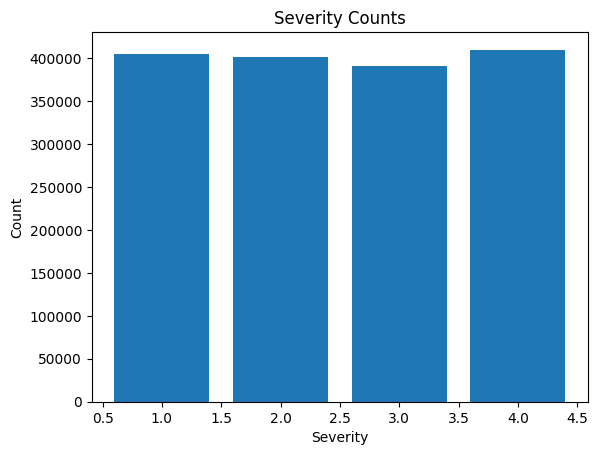

In [ ]:
plot_graph(df)

# **6. Clustering**
I use K-means algorithm which partitions the dataset into a predefined number of clusters based on the similarity of their data points. I can cluster accidents based on different features to identify high-risk areas and times when accidents are most likely to occur.

## **6.1.** K-means


In [8]:
'''
This function is designed to make it easy to perform K-means clustering
with different configurations, including various distance measures and cluster counts.
'''
def k_means(dataset,
            n_clusters,
            distance_measure,
            max_iter=20,
            features_col="features",
            prediction_col="cluster",
            random_seed=RANDOM_SEED):

  print("""Training K-means clustering using the following parameters:
  - K (n. of clusters) = {:d}
  - max_iter (max n. of iterations) = {:d}
  - distance measure = {:s}
  - random seed = {:d}
  """.format(n_clusters, max_iter, distance_measure, random_seed))

  # Train a K-means model
  kmeans = KMeans(featuresCol=features_col,
                   predictionCol=prediction_col,
                   k=n_clusters,
                   initMode="k-means||",
                   initSteps=5,
                   tol=0.000001,
                   maxIter=max_iter,
                   seed=random_seed,
                   distanceMeasure=distance_measure)
  model = kmeans.fit(dataset)

  # Make clusters
  clusters_df = model.transform(dataset)

  return model, clusters_df

In [ ]:
'''
This function evaluates the quality of clusters created by
a K-means clustering algorithm.
The Silhouette score is a valuable metric for assessing the quality of clusters.
A higher Silhouette score typically indicates better-defined and well-separated clusters,
making it a useful measure for selecting the optimal number of clusters
or evaluating the performance of a clustering algorithm.
'''
def evaluate_k_means(clusters,
                     metric_name="silhouette",
                     distance_measure="squaredEuclidean", # cosine
                     prediction_col="cluster"
                     ):

  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure,
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

In [ ]:
'''
This function allows you to systematically explore different values of K
for K-means clustering, evaluate the quality of the resulting clusters,
and store the results for further analysis or visualization.
'''
def do_clustering(df, distance_measure):
    clustering_results = {}
    for k in range(5, MAX_K_CLUSTERS + 1, 5):
        print("Running K-means using K = {:d}".format(k))
        model, clusters_df = k_means(df, k, distance_measure) # Alternatively, distance_measure="euclidean"

        if distance_measure == "euclidean":
          silhouette_k = evaluate_k_means(clusters_df) # Alternatively, distance_measure="squaredEuclidean"
        else:
          silhouette_k = evaluate_k_means(clusters_df, distance_measure=distance_measure)

        wssd_k = model.summary.trainingCost
        print("Silhouette coefficient: {:.3f}".format(silhouette_k))
        print("Within-cluster Sum of Squared Distances: {:.3f}".format(wssd_k))
        print("--------------------------------------------------------------------------------------")
        clustering_results[k] = (silhouette_k, wssd_k)

        # Free up memory space at the end of each iteration
        del model
        del clusters_df
    return clustering_results

### **6.1.1.**  Weather-related features:
   - Wind_Chill(F)
   - Wind_Speed(mph)
   - Wind_Direction
   - Precipitation(in)
   - Weather_Condition

In [9]:
numerical_cols = ["Wind_Chill(F)", "Wind_Speed(mph)", "Precipitation(in)"]

for col_name in numerical_cols:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

# Impute (fill in) missing values using the mean along each column (for default)
imputer = Imputer(inputCols=numerical_cols, outputCols=numerical_cols)
imputer_model = imputer.fit(df)
transformed_df_num = imputer_model.transform(df)

categorical_cols = ["Wind_Direction", "Weather_Condition"]

indexers = [StringIndexer(inputCol=col_name, outputCol=col_name+"_index", handleInvalid="keep") for col_name in categorical_cols]
encoders = [OneHotEncoder(inputCol=col_name+"_index", outputCol=col_name+"_encoded") for col_name in categorical_cols]

pipeline = Pipeline(stages=indexers + encoders)
training_model = pipeline.fit(transformed_df_num)
transformed_df = training_model.transform(transformed_df_num)

encoders = [stage for stage in training_model.stages if isinstance(stage, OneHotEncoder)]
for encoder in encoders:
    df_test = encoder.transform(df_test)

input_cols = [
    "Wind_Chill(F)", "Wind_Speed(mph)", "Precipitation(in)",
    "Wind_Direction_encoded", "Weather_Condition_encoded"]

# Assemble the features into a single vector column
assembler_num = VectorAssembler(inputCols=input_cols, outputCol="features")
df_assembled = assembler_num.transform(transformed_df)

In [ ]:
weather_euclidean = do_clustering(df_assembled, "euclidean")

Running K-means using K = 5
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 5
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.493
Within-cluster Sum of Squared Distances: 108844905.743
--------------------------------------------------------------------------------------
Running K-means using K = 10
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.502
Within-cluster Sum of Squared Distances: 47529217.923
--------------------------------------------------------------------------------------
Running K-means using K = 15
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 15
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.502
Within-cluster Sum of Squared Distances: 34516594.844
--------------------------------------------------------------------------------------
Running K-means using K = 20
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 20
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.473
Within-cluster Sum of Squared Distances: 27261353.581
--------------------------------------------------------------------------------------
Running K-means using K = 25
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 25
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.474
Within-cluster Sum of Squared Distances: 22868906.618
--------------------------------------------------------------------------------------
Running K-means using K = 30
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 30
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.486
Within-cluster Sum of Squared Distances: 18987764.090
--------------------------------------------------------------------------------------
Running K-means using K = 35
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 35
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.485
Within-cluster Sum of Squared Distances: 17387552.688
--------------------------------------------------------------------------------------
Running K-means using K = 40
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 40
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.467
Within-cluster Sum of Squared Distances: 15564838.640
--------------------------------------------------------------------------------------
Running K-means using K = 45
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 45
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.478
Within-cluster Sum of Squared Distances: 13741380.131
--------------------------------------------------------------------------------------
Running K-means using K = 50
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 50
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.469
Within-cluster Sum of Squared Distances: 12313381.127
--------------------------------------------------------------------------------------


In [ ]:
weather_cosine = do_clustering(df_assembled, "cosine")

Running K-means using K = 5
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 5
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


Silhouette coefficient: 0.614
Within-cluster Sum of Squared Distances: 4254.161
--------------------------------------------------------------------------------------
Running K-means using K = 10
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


Silhouette coefficient: 0.579
Within-cluster Sum of Squared Distances: 1667.291
--------------------------------------------------------------------------------------
Running K-means using K = 15
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 15
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


Silhouette coefficient: 0.449
Within-cluster Sum of Squared Distances: 1147.541
--------------------------------------------------------------------------------------
Running K-means using K = 20
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 20
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


Silhouette coefficient: 0.336
Within-cluster Sum of Squared Distances: 1021.305
--------------------------------------------------------------------------------------
Running K-means using K = 25
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 25
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


Silhouette coefficient: 0.275
Within-cluster Sum of Squared Distances: 877.510
--------------------------------------------------------------------------------------
Running K-means using K = 30
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 30
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


Silhouette coefficient: 0.252
Within-cluster Sum of Squared Distances: 875.895
--------------------------------------------------------------------------------------
Running K-means using K = 35
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 35
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


Silhouette coefficient: 0.294
Within-cluster Sum of Squared Distances: 780.488
--------------------------------------------------------------------------------------
Running K-means using K = 40
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 40
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


Silhouette coefficient: 0.255
Within-cluster Sum of Squared Distances: 765.868
--------------------------------------------------------------------------------------
Running K-means using K = 45
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 45
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


Silhouette coefficient: 0.239
Within-cluster Sum of Squared Distances: 741.609
--------------------------------------------------------------------------------------
Running K-means using K = 50
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 50
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


Silhouette coefficient: 0.247
Within-cluster Sum of Squared Distances: 708.300
--------------------------------------------------------------------------------------


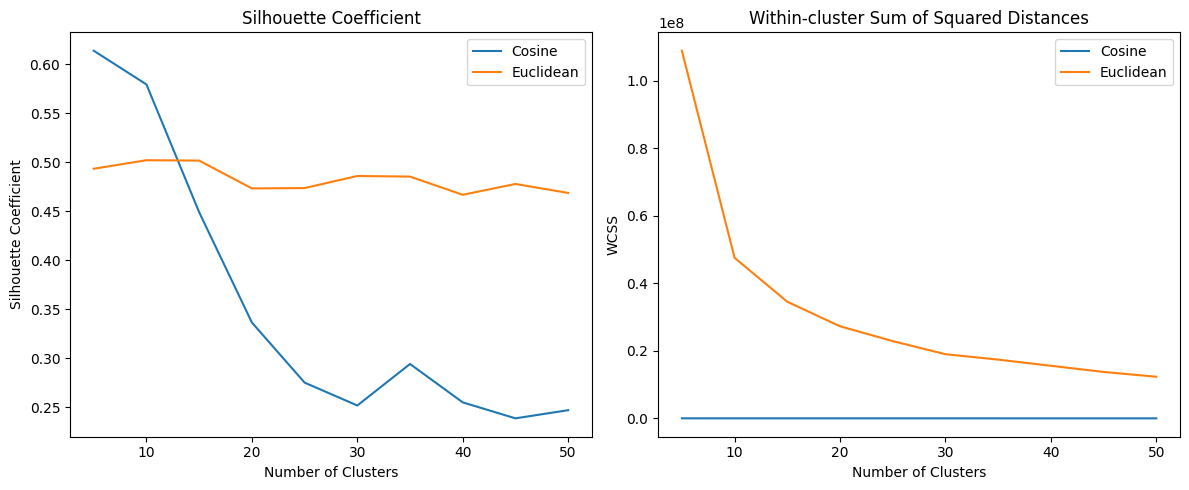

In [ ]:
# Extracting Silhouette coefficients and Within-cluster Sum of Squared Distances
cosine_silhouettes = [result[0] for result in weather_cosine.values()]
euclidean_silhouettes = [result[0] for result in weather_euclidean.values()]

cosine_wcss = [result[1] for result in weather_cosine.values()]
euclidean_wcss = [result[1] for result in weather_euclidean.values()]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(weather_cosine.keys()), cosine_silhouettes, label='Cosine')
plt.plot(list(weather_euclidean.keys()), euclidean_silhouettes, label='Euclidean')
plt.title('Silhouette Coefficient')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(weather_cosine.keys()), cosine_wcss, label='Cosine')
plt.plot(list(weather_euclidean.keys()), euclidean_wcss, label='Euclidean')
plt.title('Within-cluster Sum of Squared Distances')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
weather_model, weather_df = k_means(df_assembled, 10, "cosine")
weather_df = weather_df.withColumnRenamed("cluster", "weather_cluster")

Training K-means clustering using the following parameters:
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 20
  - distance measure = cosine
  - random seed = 42
  


24/01/13 18:52:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/13 18:52:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [ ]:
df_final = weather_df.select("id_unique", "weather_cluster", "Description", "Severity")

In [11]:
weather_model.save('weather_model')

In [ ]:
df_final.write.csv("df_weather_cluster.csv", header=True, mode='overwrite')

### **6.1.2.** Traffic-related features
Crossing, Stop, Traffic_Signal, Stop: can be used to cluster accidents based on the presence or absence of these traffic elements.

In [ ]:
#cosine distance doesn't accept zero-length element
df_transformed = df.withColumn("Traffic_Signal", when(df["Traffic_Signal"] == True, 1).otherwise(-1)) \
              .withColumn("Crossing", when(df["Crossing"] == True, 1).otherwise(-1)) \
              .withColumn("Stop", when(df["Stop"] == True, 1).otherwise(-1))

input_cols = ["Traffic_Signal", "Crossing", "Stop"]

assembler_num = VectorAssembler(inputCols=input_cols, outputCol="features")
df_assembled = assembler_num.transform(df_transformed)

In [ ]:
traffic_euclidean = do_clustering(df_assembled, "euclidean")

Running K-means using K = 5
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 5
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 0.987
Within-cluster Sum of Squared Distances: 43661.303
--------------------------------------------------------------------------------------
Running K-means using K = 10
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 1.000
Within-cluster Sum of Squared Distances: 0.000
--------------------------------------------------------------------------------------
Running K-means using K = 15
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 15
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 1.000
Within-cluster Sum of Squared Distances: 0.000
--------------------------------------------------------------------------------------
Running K-means using K = 20
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 20
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 1.000
Within-cluster Sum of Squared Distances: 0.000
--------------------------------------------------------------------------------------
Running K-means using K = 25
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 25
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 1.000
Within-cluster Sum of Squared Distances: 0.000
--------------------------------------------------------------------------------------
Running K-means using K = 30
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 30
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 1.000
Within-cluster Sum of Squared Distances: 0.000
--------------------------------------------------------------------------------------
Running K-means using K = 35
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 35
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 1.000
Within-cluster Sum of Squared Distances: 0.000
--------------------------------------------------------------------------------------
Running K-means using K = 40
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 40
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 1.000
Within-cluster Sum of Squared Distances: 0.000
--------------------------------------------------------------------------------------
Running K-means using K = 45
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 45
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 1.000
Within-cluster Sum of Squared Distances: 0.000
--------------------------------------------------------------------------------------
Running K-means using K = 50
Training K-means clustering using the following parameters:
  - K (n. of clusters) = 50
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


Silhouette coefficient: 1.000
Within-cluster Sum of Squared Distances: 0.000
--------------------------------------------------------------------------------------


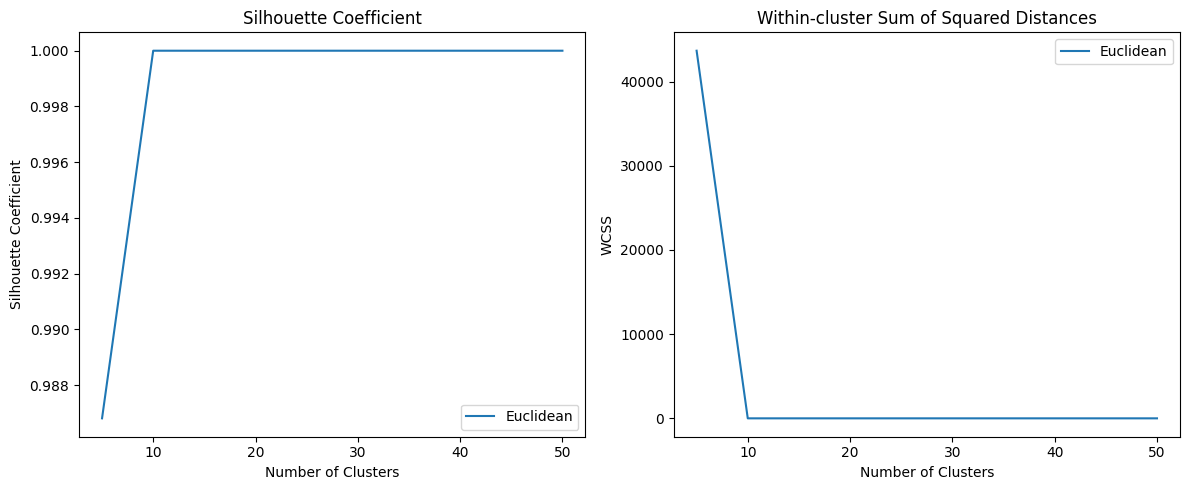

In [ ]:
# Extracting Silhouette coefficients and Within-cluster Sum of Squared Distances
euclidean_silhouettes = [result[0] for result in traffic_euclidean.values()]
euclidean_wcss = [result[1] for result in traffic_euclidean.values()]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(traffic_euclidean.keys()), euclidean_silhouettes, label='Euclidean')
plt.title('Silhouette Coefficient')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(traffic_euclidean.keys()), euclidean_wcss, label='Euclidean')
plt.title('Within-cluster Sum of Squared Distances')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
traffic_model, traffic_df = k_means(df_assembled, 10, "euclidean")
traffic_df = traffic_df.withColumnRenamed("cluster", "traffic_cluster")

Training K-means clustering using the following parameters:
  - K (n. of clusters) = 10
  - max_iter (max n. of iterations) = 20
  - distance measure = euclidean
  - random seed = 42
  


In [ ]:
df_final = df_final.join(traffic_df.select("id_unique", "traffic_cluster").distinct(), on="id_unique", how="inner")

In [ ]:
traffic_model.save('traffic_model')

## **6.2.** Save DataFrame


In [ ]:
df_final.write.csv(GDRIVE_DATA_DIR + "/df_final.csv", header=True, mode='overwrite')

# **7. Classification**


In [ ]:
tokenizer = Tokenizer(inputCol="Description", outputCol="words")
stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_final = df_final.na.fill({'Description': ''})

hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=100)
idf = IDF(inputCol="rawFeatures", outputCol="features")
indexer = StringIndexer(inputCol="Severity", outputCol="severityIndex")
feature_assembler = VectorAssembler(inputCols=["features", "weather_cluster", "traffic_cluster"], outputCol="final_features")

In [ ]:
(trainingData, testData) = df_final.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

## **7.1.** Random Forest

In [ ]:
rf = RandomForestClassifier(labelCol="severityIndex", featuresCol="final_features", numTrees=50, maxDepth=10, maxBins=32, featureSubsetStrategy="auto")
pipeline = Pipeline(stages=[tokenizer, stop_words_remover, hashingTF, idf, indexer, feature_assembler, rf])

model = pipeline.fit(trainingData)
predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(labelCol="severityIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

24/01/13 13:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1215.6 KiB
24/01/13 13:50:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/01/13 13:50:36 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/01/13 13:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1026.5 KiB
24/01/13 13:50:43 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
24/01/13 13:50:49 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB
24/01/13 13:50:50 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


Accuracy: 0.8284864507600793


In [ ]:
evaluator_multi = MulticlassClassificationEvaluator(labelCol="severityIndex", predictionCol="prediction")

precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1_score:.4f}")

24/01/13 14:07:12 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/01/13 14:07:19 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/01/13 14:07:26 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


Weighted Precision: 0.8415
Weighted Recall: 0.8285
Weighted F1-Score: 0.8278


24/01/13 14:07:48 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


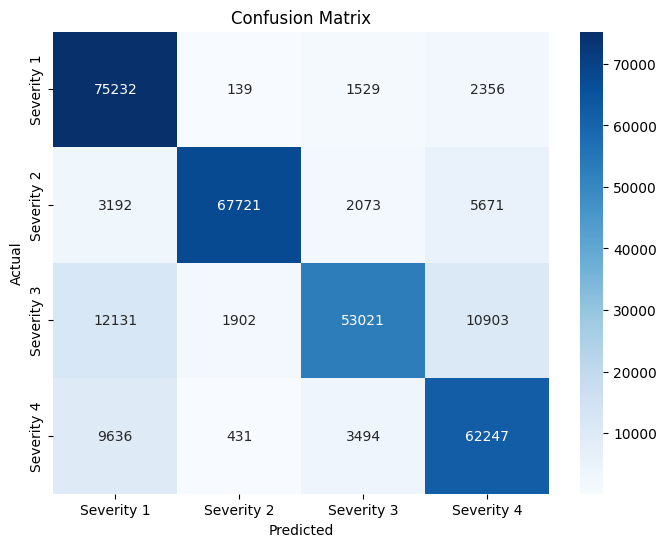

In [ ]:
predictions_pd = predictions.select("severityIndex", "prediction").toPandas()

cm = confusion_matrix(predictions_pd["severityIndex"], predictions_pd["prediction"])
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
model.save('rf_prediction_model.h5')

## **7.2.** Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="severityIndex", featuresCol="final_features", maxIter=10)
pipeline = Pipeline(stages=[tokenizer, stop_words_remover, hashingTF, idf, indexer, feature_assembler, lr])

model = pipeline.fit(trainingData)
predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(labelCol="severityIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

24/01/13 14:11:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/13 14:11:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Accuracy: 0.8027290986210127


In [ ]:
evaluator_multi = MulticlassClassificationEvaluator(labelCol="severityIndex", predictionCol="prediction")

precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1_score:.4f}")

Weighted Precision: 0.8054
Weighted Recall: 0.8027
Weighted F1-Score: 0.8012


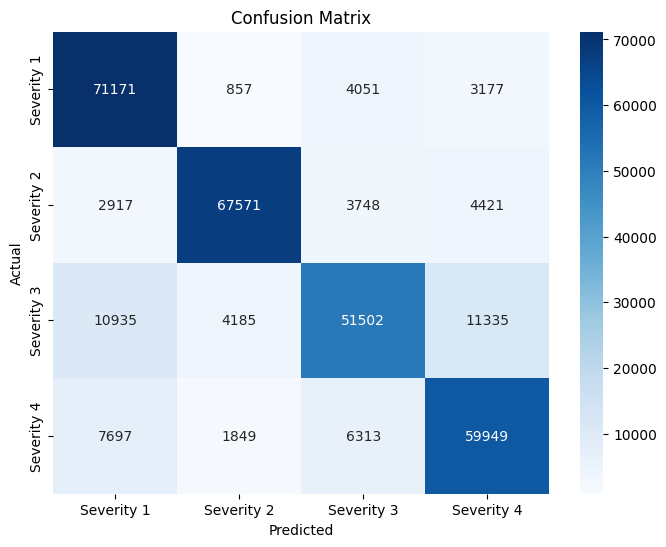

In [ ]:
predictions_pd = predictions.select("severityIndex", "prediction").toPandas()

cm = confusion_matrix(predictions_pd["severityIndex"], predictions_pd["prediction"])
target_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
model.save('lr_prediction_model.h5')

# **8. Web App**

In [ ]:
!pip install -U -q streamlit

In [ ]:
import os
os.chdir(GDRIVE_DATA_DIR)
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

In [11]:
%%writefile app.py
import streamlit as st
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer, OneHotEncoder
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

spark = SparkSession.builder.appName("AccidentApp").getOrCreate()

# Load PySpark KMeansModel
weather_model = KMeansModel.load('weather_model')
traffic_model = KMeansModel.load('weather_model')
classification_model = PipelineModel.load('rf_prediction_model')

def main():
    st.title("Accident Classification App")
    weather = weather_cluster()
    traffic = traffic_cluster()
    classification(weather, traffic)

def classification(weather, traffic):
    st.subheader("Traffic related features")
    description = st.text_area("Enter Description", "Accident on OH-32 State Route 32 Westbound at Dela Palma Rd. Expect delays.")
    weather_cluster = weather
    traffic_cluster = traffic
    classification_input = spark.createDataFrame([(description, weather_cluster, traffic_cluster)],
                                      ['Description', 'weather_cluster', 'traffic_cluster'])

    tokenizer = Tokenizer(inputCol="Description", outputCol="words")
    stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=100)
    idf = IDF(inputCol="rawFeatures", outputCol="features")

    feature_assembler = VectorAssembler(inputCols=["features", "weather_cluster", "traffic_cluster"], outputCol="final_features")
    if st.button("Classify Traffic"):
        result = classification_model.transform(classification_input)
        predicted_severity = result.select("prediction").collect()[0][0]
        st.success(f"Predicted Severity is {predicted_severity}")
    
def traffic_cluster():
    st.subheader("Traffic related features")
    traffic_signal = st.checkbox("Traffic Signal")
    crossing = st.checkbox("Crossing")
    stop = st.checkbox("Stop")
    traffic_input = spark.createDataFrame([(traffic_signal, crossing, stop)], ["Traffic_Signal", "Crossing", "Stop"])

    df_transformed = traffic_input.withColumn("Traffic_Signal", when(traffic_input["Traffic_Signal"] == True, 1).otherwise(-1)) \
              .withColumn("Crossing", when(traffic_input["Crossing"] == True, 1).otherwise(-1)) \
              .withColumn("Stop", when(traffic_input["Stop"] == True, 1).otherwise(-1))
    input_cols_pred = ["Traffic_Signal", "Crossing", "Stop"]

    assembler_num = VectorAssembler(inputCols=input_cols_pred, outputCol="features")
    traffic_input_pred = assembler_num.transform(df_transformed)

    try:
        result = traffic_model.transform(traffic_input_pred)
        prediction_column = 'cluster'  
        if len(result.select(prediction_column).collect()) > 0:
            predicted_cluster = result.select(prediction_column).collect()[0][prediction_column]
            #st.write("Traffic Cluster:", predicted_cluster)
        else:
            st.warning("No cluster prediction available.")
    except Exception as e:
        st.error(f"Error during model prediction: {str(e)}")

    return predicted_cluster


def weather_cluster():
    st.subheader("Weather related features")
    wind_chill = st.number_input("Enter Wind Chill (F):", min_value=0.0)
    wind_speed = st.number_input("Enter Wind Speed (mph):", min_value=0.0)
    precipitation = st.number_input("Enter Precipitation (in):", min_value=0.0)
    wind_direction = st.selectbox("Select Wind Direction:", ["North", "South", "East", "West"])
    weather_condition = st.selectbox("Select Weather Condition:", ["Fog", "Cloudy", "Haze", "Fair", "Mostly Cloudy", "Light Snow"])

    weather_input = spark.createDataFrame([(wind_chill, wind_speed, precipitation, wind_direction, weather_condition)],
                                           ['Wind_Chill(F)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Wind_Direction', 'Weather_Condition'])

    numerical_cols = ["Wind_Chill(F)", "Wind_Speed(mph)", "Precipitation(in)"]
    imputer = Imputer(inputCols=numerical_cols, outputCols=numerical_cols)
    imputer_model = imputer.fit(weather_input)
    weather_input = imputer_model.transform(weather_input)

    categorical_cols = ["Wind_Direction", "Weather_Condition"]
    indexers = [StringIndexer(inputCol=col_name, outputCol=col_name+"_index", handleInvalid="keep") for col_name in categorical_cols]
    encoders = [OneHotEncoder(inputCol=col_name+"_index", outputCol=col_name+"_encoded") for col_name in categorical_cols]

    pipeline = Pipeline(stages=indexers + encoders)
    model = pipeline.fit(weather_input)
    weather_input = model.transform(weather_input)

    input_cols_pred = numerical_cols + [col_name+"_encoded" for col_name in categorical_cols]

    assembler_num = VectorAssembler(inputCols=input_cols_pred, outputCol="features")
    weather_input = assembler_num.transform(weather_input)
   
    try:
        result = weather_model.transform(weather_input)
        prediction_column = 'cluster'  
        if len(result.select(prediction_column).collect()) > 0:
            predicted_cluster = result.select(prediction_column).collect()[0][prediction_column]
            #st.write("Weather Cluster:", predicted_cluster)
        else:
            st.warning("No cluster prediction available.")
    except Exception as e:
        st.error(f"Error during model prediction: {str(e)}")

    return predicted_cluster

if __name__ == "__main__":
    main()

Overwriting app.py


In [12]:
!streamlit run app.py --server.maxMessageSize=2500


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.9:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/13 23:15:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/13 23:15:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/01/13 23:15:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/01/13 23:16:03 WARN StringIndexerModel: Input column Severity does not exist during transformation. Skip StringIndexerModel for this column.
24/01/13 23:16:03 WARN DAGScheduler: Broadcasting l